In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
import cupy as cp
import os
import random
import xraylib
%matplotlib inline

cp.cuda.Device(0).use()

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

# Init data sizes and parametes of the PXM of ID16A

In [ ]:
n = 512  # object size in each dimension
ntheta = 180  # number of angles (rotations)

pn = 64  # tomography chunk size for GPU processing
ptheta = 180  # holography chunk size for GPU processing

center = n/2  # rotation axis
theta = np.linspace(0, np.pi, ntheta).astype('float32')  # projection angles

# ID16a setup
voxelsize = 10e-9*2048/n  # object voxel size
energy = 33.35  # [keV] xray energy
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy
focusToDetectorDistance = 1.28
ndist = 4
sx0 = 3.7e-4
z1 = np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:ndist]-sx0
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
norm_magnifications = magnifications/magnifications[0]
# scaled propagation distances due to magnified probes
distances = distances*norm_magnifications**2

z1p = z1[0]  # positions of the probe and code for reconstruction
z2p = z1-np.tile(z1p, len(z1))
# magnification when propagating from the probe plane to the detector
magnificationsp = (z1p+z2p)/z1p
# propagation distances after switching from the point source wave to plane wave,
distancesp = (z1p*z2p)/(z1p+z2p)
norm_magnificationsp = magnificationsp/magnificationsp[0]  # normalized magnifications
# scaled propagation distances due to magnified probes
distancesp = distancesp*norm_magnificationsp**2
distancesp = distancesp*(z1p/z1)**2

## Read real and imaginary parts of the refractive index u = delta+i beta

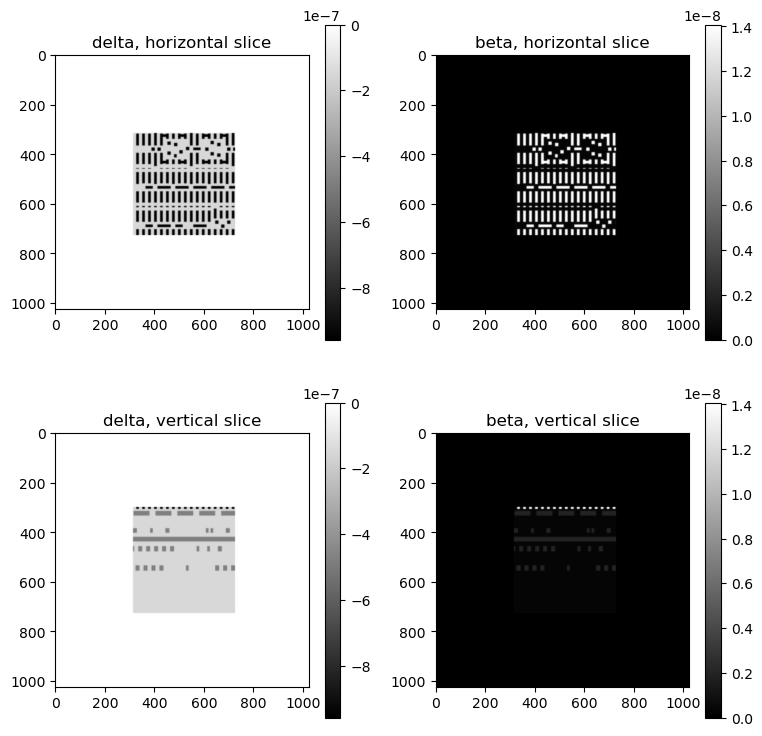

In [ ]:
# Load a 3D object
beta0 = dxchange.read_tiff('data/beta-chip-192.tiff')
delta0 = dxchange.read_tiff('data/delta-chip-192.tiff')
delta0 = ndimage.zoom(delta0,n/192,order=1)
beta0 = ndimage.zoom(beta0,n/192,order=1)

# pad with zeros
beta = np.zeros([2*n, 2*n, 2*n], dtype='float32')
delta = np.zeros([2*n, 2*n, 2*n], dtype='float32')
delta[n-delta0.shape[0]//2:n+delta0.shape[0]//2,n-delta0.shape[0]//2:n+delta0.shape[0]//2,n-delta0.shape[0]//2:n+delta0.shape[0]//2] = delta0
beta[n-delta0.shape[0]//2:n+delta0.shape[0]//2,n-delta0.shape[0]//2:n+delta0.shape[0]//2,n-delta0.shape[0]//2:n+delta0.shape[0]//2] = beta0

u = delta+1j*beta
u = u.astype('complex64')/2 # /2 to have max phase as 2

fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(u[300].real,cmap='gray')
axs[0,0].set_title('delta, horizontal slice')
fig.colorbar(im)
im=axs[0,1].imshow(u[300].imag,cmap='gray')
axs[0,1].set_title('beta, horizontal slice')
fig.colorbar(im)
im=axs[1,0].imshow(u[:,n].real,cmap='gray')
axs[1,0].set_title('delta, vertical slice')
fig.colorbar(im)
im=axs[1,1].imshow(u[:,n].imag,cmap='gray')
axs[1,1].set_title('beta, vertical slice')
fig.colorbar(im)

# Make structured illumination

psiill.shape=(1, 1024, 1024)


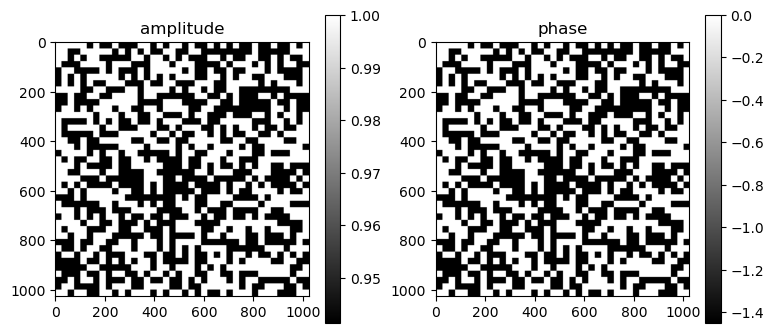

In [ ]:

ill_feature_size = 1e-6
nill = int(2*n*voxelsize//(ill_feature_size*2))*2


random.seed(10)
ill_ids = random.sample(range(0, nill*nill), nill*nill//2)
ill = np.zeros([nill*nill],dtype='bool')
ill[ill_ids] = 1
ill = ill.reshape(nill,nill)
ill = ndimage.zoom(ill,[2*n/nill,2*n/nill],order=0,grid_mode=True,mode='grid-wrap')

delta = 1-xraylib.Refractive_Index_Re('Au',energy,19.3)
beta = xraylib.Refractive_Index_Im('Au',energy,19.3)
thickness = 3*1e-6/voxelsize # thickness in pixels

# form Transmittance function
Rill = ill*(-delta+1j*beta)*thickness 
psiill = np.exp(1j * Rill * voxelsize * 2 * np.pi / wavelength).astype('complex64')
psiill = psiill[np.newaxis]



psiill[:]=1



print(f'{psiill.shape=}')
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psiill[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psiill[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

In [ ]:
shifts_code = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/8

## Create a solver class for tomography, use double sizes

In [ ]:
tslv = holotomo.SolverTomo(theta, ntheta, 2*n, 2*n, 2*pn, 2*center)

note pn parameter is used to define the number of slices for simultaneous processing by 1 gpu. Currently pn=n. If the gpu does not have enough memory then pn should  be decreased

## Create a solver class for holography

In [ ]:
pslv = holotomo.SolverHolo(ntheta, n, ptheta, voxelsize, energy, distances, norm_magnifications, distancesp)

note ptheta parameter is used to define the number of angles for simultaneous processing by 1 gpu. Currently pntheta=ntheta. If the gpu does not have enough memory then ptheta should  be decreased
norm_magnifications are magnifications for different distances, normalized by the magnification for the first distance

## Compute tomographic projection data via the Fourier based method, $\mathcal{R}u$:

In [ ]:
Ru = tslv.fwd_tomo_batch(u)

fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.real(Ru[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.imag(Ru[1]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

CUDARuntimeError: cudaErrorIllegalAddress: an illegal memory access was encountered

## Convert it to the transmittance function $e^{\frac{2\pi j}{\lambda} \mathcal{R} u }$

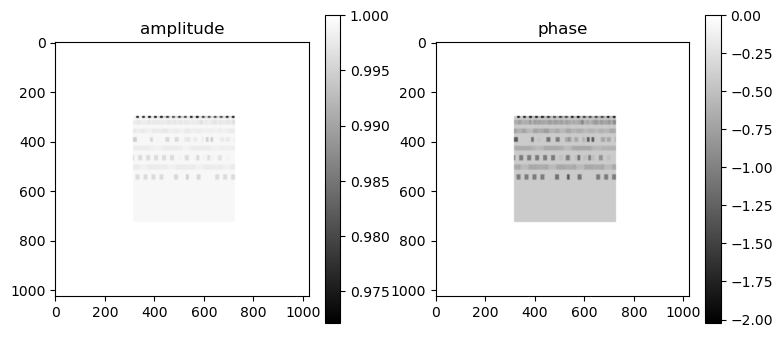

In [ ]:
psi = pslv.exptomo(Ru)
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
axs[0].set_title('amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title('phase')
fig.colorbar(im)

## Read a reference image previously recovered by the NFP (Near-field ptychogarphy) method at ID16A. 

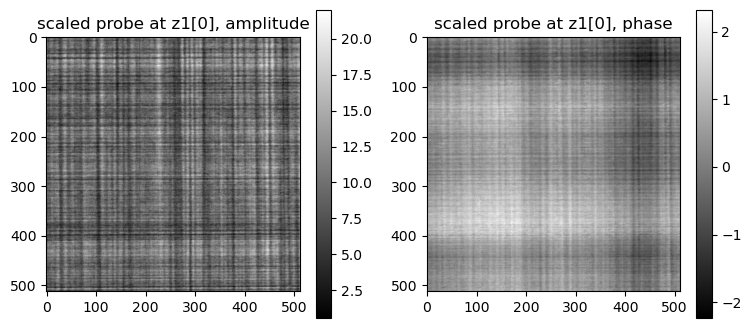

In [ ]:
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[0:1]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[0:1]
prb = prb_abs*np.exp(1j*prb_phase).astype('complex64')  
fig, axs = plt.subplots(1, 2, figsize=(9, 4))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)

In [ ]:
shifts = (np.random.random([ndist, ntheta, 2]).astype('float32')-0.5)*n/16*0#*norm_magnifications[:,np.newaxis,np.newaxis]

# Compute holographic projections for all angles and all distances

In [ ]:
shifts_ref = shifts/norm_magnifications[:,np.newaxis,np.newaxis]
fpsi = pslv.fwd_holo_batch(psi,prb,shifts_ref,psiill,shifts_code)
fpsi0 = pslv.fwd_holo_batch(psi,prb*0+1,shifts_ref,psiill,shifts_code) # ignore probe

pslv0 = holotomo.SolverHolo(1, n, 1, voxelsize, energy, distances[:1], norm_magnifications[:1], distancesp[:1]) 
fref = pslv0.fwd_holo_batch(psi*0+1,prb,shifts_ref[:1,:1]*0,psiill,shifts_code[:1,:1]*0) # ignore sample

## Take squared absolute value to simulate data on the detector, ref fields, and data with homogeneous ref fields  

In [ ]:
data = np.abs(fpsi)**2
ref = np.abs(fref)**2
data0 = np.abs(fpsi0)**2

# !!!Note that simple ref-field correction creates artifacts!!! Demonstration:

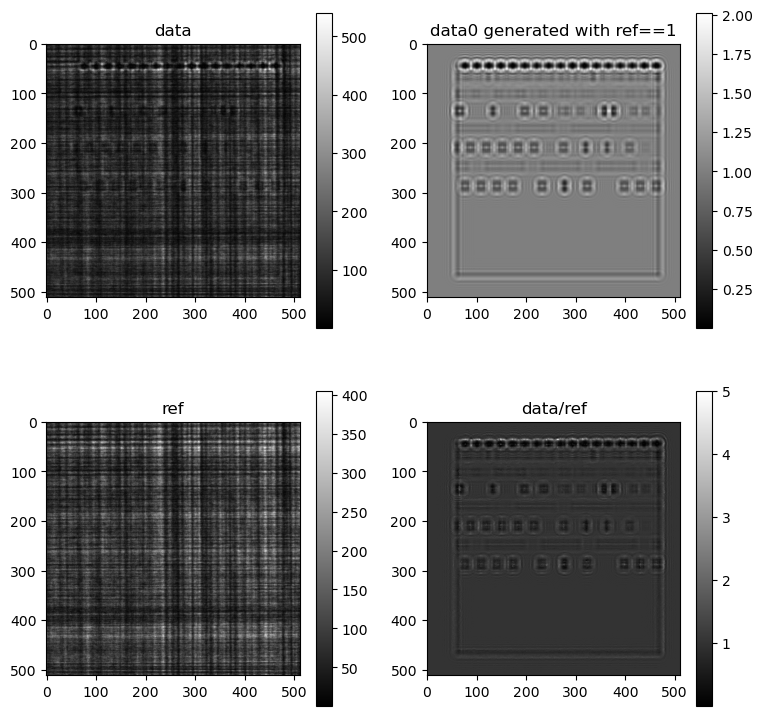

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data')
fig.colorbar(im)
im=axs[0,1].imshow(data0[0,0],cmap='gray')
axs[0,1].set_title('data0 generated with ref==1')
fig.colorbar(im)
im=axs[1,0].imshow(ref[0,0],cmap='gray')
axs[1,0].set_title('ref')
fig.colorbar(im)
im=axs[1,1].imshow(data[0,0]/ref[0,0],cmap='gray',vmax=5)
axs[1,1].set_title('data/ref')
fig.colorbar(im)

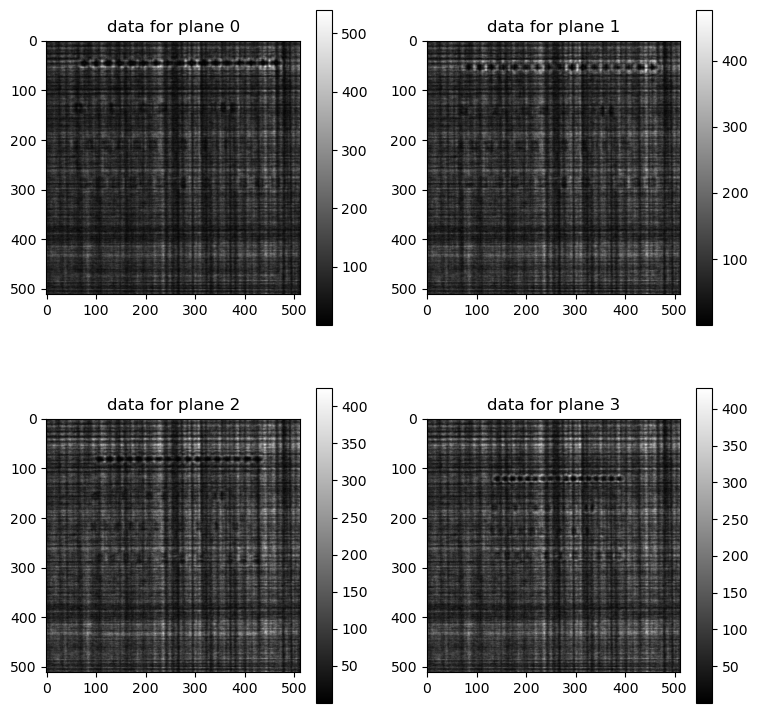

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0],cmap='gray')
axs[0,0].set_title('data for plane 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0],cmap='gray')
axs[0,1].set_title('data for plane 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[2,1],cmap='gray')
axs[1,0].set_title('data for plane 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[-1,1],cmap='gray')
axs[1,1].set_title('data for plane 3')
fig.colorbar(im)

# Save data nd ref fields

In [ ]:
for k in range(len(distances)):
    dxchange.write_tiff(data[k],f'data/modeling/data_chip_{n}_{k}',overwrite=True)
dxchange.write_tiff(ref[0,0],f'data/modeling/ref_chip_{n}_0',overwrite=True)

dxchange.write_tiff(np.abs(psiill),f'data/modeling/psiill_abs_{n}',overwrite=True)
dxchange.write_tiff(np.angle(psiill),f'data/modeling/psiill_angle_{n}',overwrite=True)

np.save('shifts',shifts)
np.save('shifts_code',shifts_code)
